In [ ]:
'''
This script takes the csv files  and filters out the words which are not present in UMLS.
'''

import argparse
from quickumls import QuickUMLS
import pandas as pd
import glob


umls_path = '/path/to/umls'
matcher = QuickUMLS(umls_path,similarity_name='cosine',threshold=0.95) 

In [ ]:
from collections import defaultdict
counter_PAC = defaultdict(int)
for csv_path in ['../../../../TxtInputFiles/PAC_input.txt']:

    print(f'Starting for {csv_path}.....')
    lines_PAC = open(csv_path).readlines()

    for idx,abs in enumerate(lines_PAC):
        if idx%100 == 0: print(f'Processed till {idx+1}... {len(counter_PAC)} are considered till now.')

        flag = 0
        d = matcher.match(abs, best_match=True, ignore_syntax=False)
        if len(d) == 0:
            continue
        
        else:
            for l in d:
                counter_PAC[l[0]['ngram']] += 1
                
    if idx%10000 == 0: print(f'Processed till {idx+1}... {len(counter_PAC)} are considered till now.')

    # df.to_csv('./%sWithConsiderFlag_AllSemTypes.csv'%csv_path.split('/')[-1][:-4],index=False)

In [ ]:
import pandas as pd

list_tokens = list(counter_PAC.keys())
val_tokens = list(counter_PAC.values())


In [ ]:
df = pd.DataFrame({'Tokens':list_tokens,'Count':val_tokens})
df.to_csv('PAC_Tokens.csv',index=False)

In [ ]:
import numpy as np
np.percentile(val_tokens,[0,10,25,50,75,90,95,90,100])

In [ ]:
from collections import defaultdict
import json
counter_PAC = defaultdict(int)
for csv_path in ['./EBM_Train.jsonl']:

    print(f'Starting for {csv_path}.....')
    lines_PAC = open(csv_path).readlines()
    lines_PAC = [json.loads(l)['prompt'] for l in lines_PAC]

    for idx,abs in enumerate(lines_PAC):
        if idx%100 == 0: print(f'Processed till {idx+1}... {len(counter_PAC)} are considered till now.')

        flag = 0
        d = matcher.match(abs, best_match=True, ignore_syntax=False)
        if len(d) == 0:
            continue
        
        else:
            for l in d:
                counter_PAC[l[0]['ngram']] += 1
                
    if idx%100 == 0: print(f'Processed till {idx+1}... {len(counter_PAC)} are considered till now.')

    # df.to_csv('./%sWithConsiderFlag_AllSemTypes.csv'%csv_path.split('/')[-1][:-4],index=False)

In [ ]:
import pandas as pd

list_tokens = list(counter_PAC.keys())
val_tokens = list(counter_PAC.values())

df = pd.DataFrame({'Tokens':list_tokens,'Count':val_tokens})
df.to_csv('EBM_Tokens.csv',index=False)

In [ ]:
import pandas as pd
df_PAC = pd.read_csv('PAC_Tokens.csv')
df_BioASQ = pd.read_csv('EBM_Tokens.csv')

df_BioASQ

In [ ]:
df_BioASQ['Count'].describe()

In [ ]:
from collections import defaultdict
tokens_PAC = df_PAC.set_index('Tokens')['Count'].to_dict()
tokens_PAC_words = defaultdict(int)

tokens_BioASQ = df_BioASQ.set_index('Tokens')['Count'].to_dict()
tokens_BioASQ_words = defaultdict(int)

import re
pattern = r"^[A-Za-z▁]+$"

for key,val in tokens_PAC.items():
    try:
      for word in key.split():  
        if re.match(pattern,word.strip()):
            tokens_PAC_words[word] += val
    except: pass
  
for key,val in tokens_BioASQ.items():
    try:
      for word in key.split():  
        if re.match(pattern,word.strip()):
            tokens_BioASQ_words[word] += val
    except: pass


In [ ]:
df_tokens_PAC_words = pd.DataFrame(list(tokens_PAC_words.items()), columns=['Word', 'Count'])
print(df_tokens_PAC_words)

df_BioASQ_words = pd.DataFrame(list(tokens_BioASQ_words.items()), columns=['Word', 'Count'])
print(df_BioASQ_words)

In [ ]:
top_50_percent_PAC = df_tokens_PAC_words.nlargest(int(len(df_tokens_PAC_words) * 0.5), 'Count')
top_50_percent_BioASQ = df_BioASQ_words.nlargest(int(len(df_BioASQ_words) * 0.5), 'Count')

print(top_50_percent_PAC)
print(top_50_percent_BioASQ)

In [ ]:
from transformers import AutoTokenizer

tokenier = AutoTokenizer.from_pretrained('mistralai/Mistral-7B-v0.1')

In [ ]:
tokenier

In [ ]:
top_50_percent_BioASQ['Splits'] = top_50_percent_BioASQ['Word'].apply(lambda x: len(tokenier.tokenize(x)))
top_50_percent_PAC['Splits'] = top_50_percent_PAC['Word'].apply(lambda x: len(tokenier.tokenize(x)))


In [ ]:
top_50_percent_PAC_1 = top_50_percent_PAC[top_50_percent_PAC['Splits'] > 1]
top_50_percent_BioASQ_1 = top_50_percent_BioASQ[top_50_percent_BioASQ['Splits'] > 1]

lookup_table_1 = top_50_percent_BioASQ_1[top_50_percent_BioASQ_1['Word'].isin(top_50_percent_PAC_1['Word'])]
lookup_table_1.to_csv('EBM_SplitMoreThan1_OOV.csv',index=False)

In [ ]:
import os
os.mkdir('./EBM_Lookup_SplitMoreThan3')
os.mkdir('./EBM_Lookup_SplitMoreThan2')


In [1]:
import pandas as pd
import os

lookup_table_1 = pd.read_csv('./EBM_SplitMoreThan1_OOV.csv')
lookup_table_words_1 = lookup_table_1['Word'].to_list()

# os.mkdir('./EBM_Lookup_SplitMoreThan1')

# for i in range(50,501,50):
#     print(i)
#     dump_words = lookup_table_words_1[:i]#[:i+500]
#     with open(f'EBM_Lookup_SplitMoreThan1/EBM_Lookup_{i}.txt','w') as f: #{i+500}.txt','w') as f:
#         f.write('\n'.join([f'''▁{x}\t{-32000-idx}''' for idx,x in enumerate(dump_words)]))
#         f.write('\n')
#     f.close()
    
# lookup_table_words_2 = lookup_table_2['Word'].to_list()
# for i in [50,100,200,500,1000,1500,2000]:
#     print(i)
#     dump_words = lookup_table_words_2[:i]
#     with open(f'EBM_Lookup_SplitMoreThan2/EBM_Lookup_{i}.txt','w') as f: #{i+500}.txt','w') as f:
#         f.write('\n'.join([f'''▁{x}\t{-32000-idx}''' for idx,x in enumerate(dump_words)]))
#         f.write('\n')
#     f.close()

# lookup_table_words_3 = lookup_table_3['Word'].to_list()
# for i in [50,100,200,500,1000,1500,2000]: 
#     print(i)
#     dump_words = lookup_table_words_3[:i]
#     with open(f'EBM_Lookup_SplitMoreThan3/EBM_Lookup_{i}.txt','w') as f: #{i+500}.txt','w') as f:
#         f.write('\n'.join([f'''▁{x}\t{-32000-idx}''' for idx,x in enumerate(dump_words)]))
#         f.write('\n')
#     f.close()

In [3]:
from collections import defaultdict
import os
# os.mkdir('./EBM_Lookup_SplitMoreThan1_Also_Add_As_Subwords')


for i in range(50,501,50):
    dump_words = lookup_table_words_1[:i]
    list_words_to_add = defaultdict(list)
    for word1 in dump_words:
        list_words_to_add[f'▁{word1}'].append(word1)
        for word2 in lookup_table_words_1:
            if word2.startswith(word1) and word1 != word2:
                list_words_to_add[f'▁{word1}'].append(word2)
                continue
            if word1 != word2 and word1 in word2 and not word2.startswith(word1):
                list_words_to_add[word1].append(word2)
            
    print(i,len(list_words_to_add))
    dump_words = list(list_words_to_add.keys()) 
    with open(f'EBM_Lookup_SplitMoreThan1_Also_Add_As_Subwords/EBM_Lookup_{i}.txt','w') as f: #{i+500}.txt','w') as f:
        f.write('\n'.join([f'''{x}\t{-32000-idx}''' for idx,x in enumerate(dump_words)]))
        f.write('\n')
    f.close()

50 60
100 118
150 173
200 228
250 280
300 335
350 388
400 440
450 493
500 546


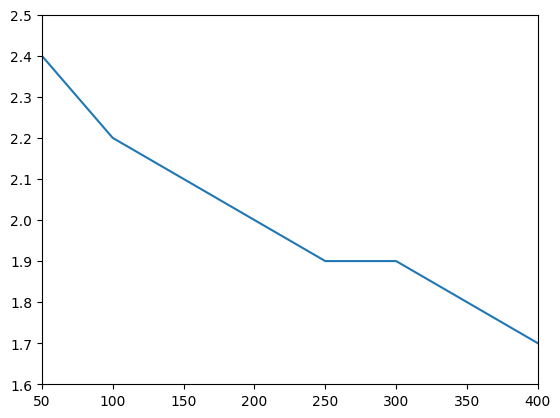

In [6]:
x = [50,100,150,200,250,300,350,400]
y= [2.4,2.25,2.13,2.02,1.95,1.87,1.8,1.74]

from matplotlib import pyplot as plt
y_r = [round(i,1) for i in y]
plt.plot(x,y_r)
plt.ylim(1.6,2.5)
plt.xlim(50,400)
plt.show()

In [ ]:
y_r